# Timeseries at points

In this example. we will generate a GeoDataFrame with airport names and their coordinates. We will use those points to build a timeseries of precipitation at those locations. 

First, we import `emaremes` and `geopandas` to build our GeoDataFrame.

In [1]:
import geopandas as gpd
from pandas import Timestamp, Timedelta
from shapely.geometry import Point

import emaremes as mrms

Then, fetch hourly precipitation data for on the days during Hurricaine Helene:

In [2]:
mrms.fetch.path_config.set_prefered("./data")

gribfiles = mrms.fetch.timerange(
    Timestamp("2024-09-26T12:00:00"),
    Timestamp("2024-09-28T00:00:00"),
    frequency=Timedelta(minutes=60),
)

Prefered path to store *new* Gribfiles is  data


Now, let's create a geodataframe with three airports:

In [3]:
airports = {
    "Asheville Regional Airport": Point(-82.541, 35.436),
    "Jacksonville International Airport": Point(-81.689, 30.494),
    "Hartsfield-Jackson Atlanta International Airport": Point(-84.428, 33.641),
}

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(airports.keys(), geometry=list(airports.values()), columns=["Airport Name"], crs="EPSG:4326")

gdf["Code"] = ["AVL", "JAX", "ATL"]

gdf

,Airport Name,geometry,Code
0,Asheville Regional Airport,POINT (-82.541 35.436),AVL
1,Jacksonville International Airport,POINT (-81.689 30.494),JAX
2,Hartsfield-Jackson Atlanta International Airport,POINT (-84.428 33.641),ATL


We can use the `explore` method in geopandas to display a map of the data.

In [ ]:
gdf.explore(column="Airport Name", categorical=True, zoom_start=7, cmap="Dark2", marker_kwds={"radius": 10})

To generate a timeseries in points, we use the `ts.point` module. For a single time step, a single MRMS GRIB file is queried, which returns a tuple with the datetime and the value at the points.

In [5]:
mrms.ts.point.query_single_file(gribfiles[0], gdf.set_index("Code"))

(np.datetime64('2024-09-26T12:00:00.000000000'),
 {'AVL': 29.0, 'JAX': 0.0, 'ATL': 3.5999999046325684})

That is basically the building block to generate a timeseries. Passing the list of files to `ts.point.query_files`, emaremes will parallelize the process of opening each dataset and querying the points. This function will return a pandas dataframe with the data for each point. 

In [6]:
df = mrms.ts.point.query_files(gribfiles, gdf.set_index("Code"))
df

,AVL,JAX,ATL
timestamp,,,
2024-09-26 12:00:00+00:00,29.0,0.0,3.600000
2024-09-26 13:00:00+00:00,4.3,0.0,0.500000
2024-09-26 14:00:00+00:00,1.6,0.0,0.400000
2024-09-26 15:00:00+00:00,0.9,0.0,0.600000
2024-09-26 16:00:00+00:00,1.5,0.0,4.300000
2024-09-26 17:00:00+00:00,1.5,0.0,1.900000
2024-09-26 18:00:00+00:00,1.8,0.0,2.600000
2024-09-26 19:00:00+00:00,4.5,0.0,16.600000
2024-09-26 20:00:00+00:00,0.5,0.0,2.900000


Notice that the column names of the retuned dataframe are the index in the geodataframe.

<Axes: xlabel='timestamp'>

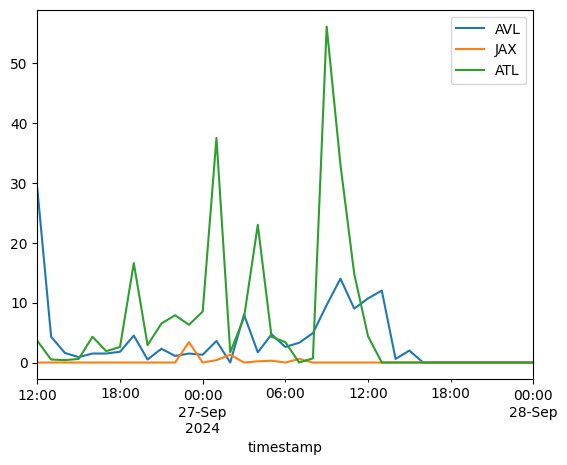

In [7]:
df.plot()